In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import pickle

from sklearn.metrics import adjusted_rand_score

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

In [4]:
model

KMeans(max_iter=500, n_init=9, random_state=42, tol=1e-05)

In [5]:
with open("transformer.pkl", "rb") as f:
    transformer = pickle.load(f)

In [6]:
with open("reducer.pkl", "rb") as f:
    reducer = pickle.load(f)

## Segmentation du jeu de données

On crée une liste de différents segments du dataframe, triés par mois, et échantillonés pour qu'ils aient la même taille entre février 2017 et octobre 2017. A chaque segment, on va appliquer le même transformer et le même reducer qui ont servi à l'entraînement de notre modèle.

In [7]:
data['date_last_order'] = pd.to_datetime(data['date_last_order']).dt.to_period('M')

In [8]:
data['date_last_order'].value_counts()

2017-11    6759
2018-05    6745
2018-03    6729
2018-01    6547
2018-08    6411
2018-04    6390
2018-02    6126
2018-06    5971
2018-07    5879
2017-12    5344
2017-10    4186
2017-08    3917
2017-09    3884
2017-07    3568
2017-05    3256
2017-06    2900
2017-03    2365
2017-04    2100
2017-02    1517
2017-01     638
2016-10     253
Freq: M, Name: date_last_order, dtype: int64

On sélectionne les périodes sur lesquelles on a au moins 2000 individus.

In [9]:
l_dates = ['2017-03',
           '2017-04',
           '2017-05',
           '2017-06',
           '2017-07',
           '2017-08',
           '2017-09',
           '2017-10',
           '2017-11',
           '2017-12',
           '2018-01',
           '2018-02',
           '2018-03',
           '2018-04',
           '2018-05',
           '2018-06',
           '2018-07',
           '2018-08'
]

In [10]:
l_data = []

for date in l_dates:
    X = data[data['date_last_order'] == date].sample(n=2100, random_state=42)
    X = X.drop(['Unnamed: 0', 'date_last_order'], axis=1)
    embedded_X = reducer.transform(transformer.transform(X))
    l_data.append(embedded_X)


## Mesure de l'ARI

In [11]:
from sklearn.cluster import KMeans

X0 = l_data[0]

model_0 = KMeans(max_iter=500, n_init=9, random_state=42, tol=1e-05)
model_0.fit(X0)

l_score_ARI = []

for X in l_data:
    
    new_model = KMeans(max_iter=500, n_init=9, random_state=42, tol=1e-05)
    new_model.fit_predict(X)
    l_score_ARI.append(adjusted_rand_score(model_0.predict(X), new_model.labels_))
    

## Visualisation de la simulation

In [12]:
ARI_simulation = pd.DataFrame()

In [13]:
ARI_simulation['Period'] = pd.Series(l_dates)
ARI_simulation['ARI Score'] = pd.Series(l_score_ARI)

In [14]:
ARI_simulation

,Period,ARI Score
0,2017-03,1.000000
1,2017-04,0.829897
2,2017-05,0.802712
3,2017-06,0.828709
4,2017-07,0.869943
5,2017-08,0.832311
6,2017-09,0.832942
7,2017-10,0.853089
8,2017-11,0.859914
9,2017-12,0.664008


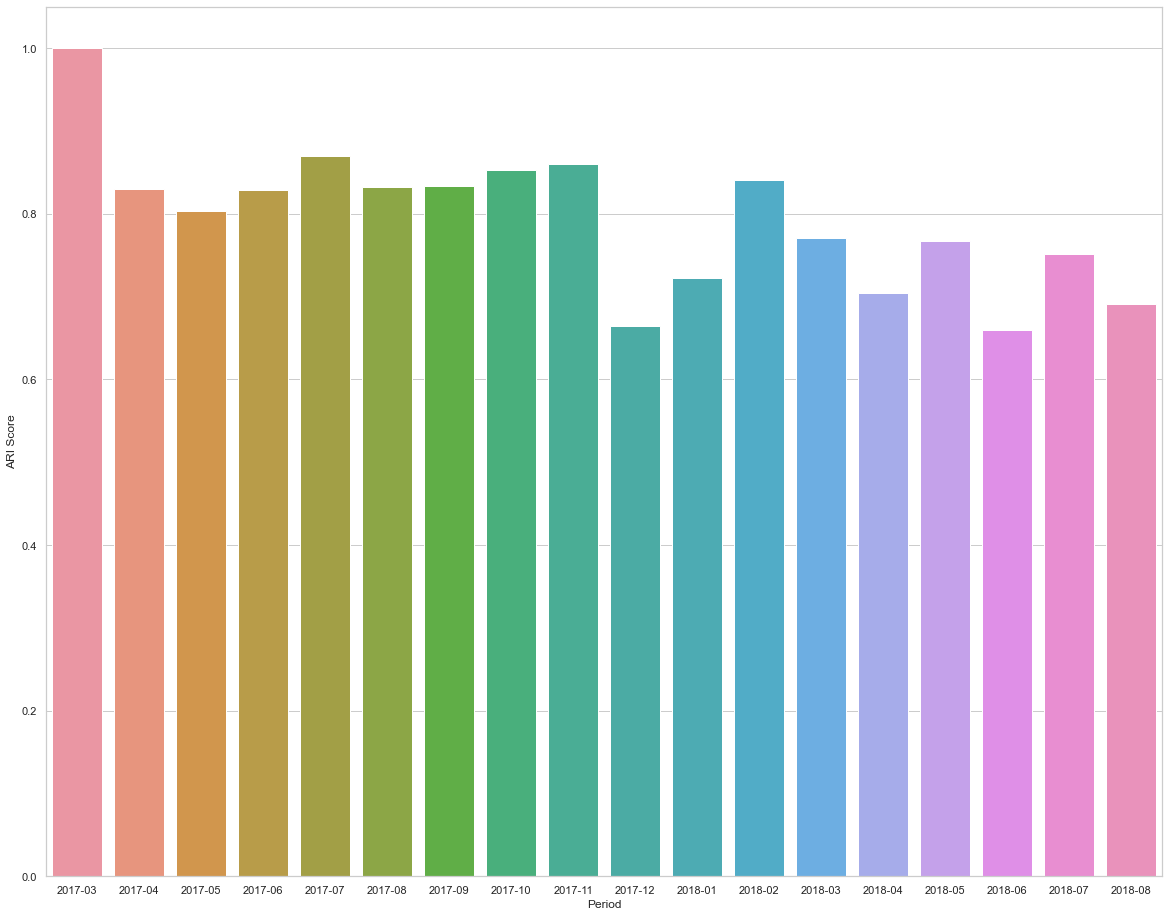

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 16))
sns.set_theme(style="whitegrid")

ax = sns.barplot(x="Period", y="ARI Score", data=ARI_simulation)